# **Wallmart Sales Projection Using Time Series Analysis**

### a. **Problem Statement**

A retail store that has multiple outlets across the country are facing issues in managing the
inventory - to match the demand with respect to supply.


### b. **Project Objective**

To build useful insights using the data and make prediction models to forecast the sales for
X number of months/years

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#import specific forecasting tools

from statsmodels.tsa.seasonal import seasonal_decompose # to plot components of time series
from statsmodels.tsa.statespace.tools import diff

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from statsmodels.tsa.arima_model import *

In [ ]:
#Converting Datatype of Date Column to DateTime and Seting it as Index Column
data1 = pd.read_csv('Walmart.csv', parse_dates=['Date'], index_col= 'Date')

### c. **Data Description**

In [ ]:
data1.head()

In [ ]:
data1.shape  #We have 6435 Rows and 7 Columns

In [ ]:
data1.info()   #Data Types are Correcctly Attributed

In [ ]:
data1.describe()   #Statistical Analysis of Data

In [ ]:
sns.heatmap(data1.corr(), cmap = 'viridis', annot=True); #Both Negative and Positive Correlations Exist in our data

### d. **Data Pre Processing & Inspiration**

d.1. **Feature Engineering**

**Duplicates**

In [ ]:
data1.duplicated().sum()  #No Duplicates

0

**Null Values**

In [ ]:
data1.isnull().sum()  #No Null Values

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

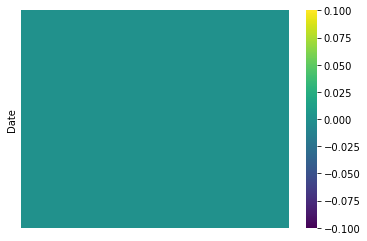

In [ ]:
sns.heatmap(data1.isnull(), yticklabels= False, xticklabels=False, cmap = 'viridis');
#Visualizing if null values are present

**Outliers**

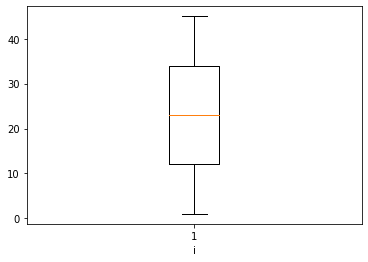

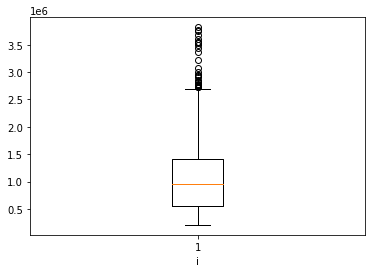

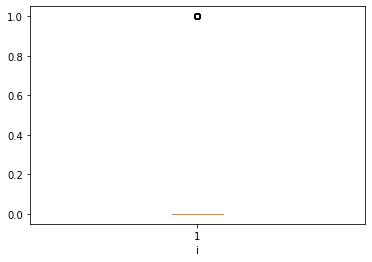

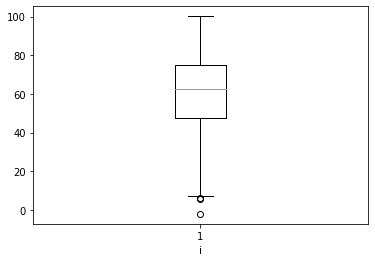

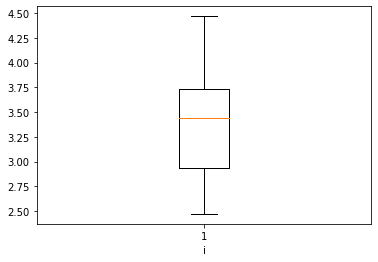

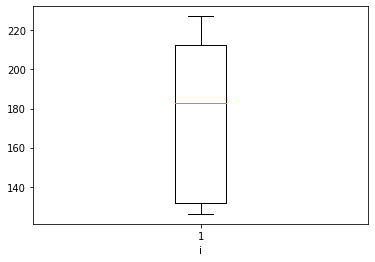

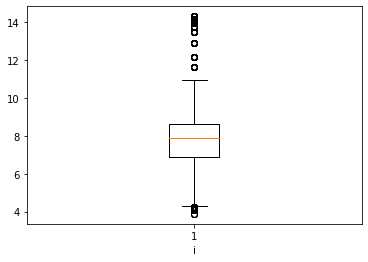

In [ ]:
for i in data1.columns:  #Since in time series it is not important to remove Outliers
  if data1[i].dtypes != object:
    plt.boxplot(data1[i])
    plt.xlabel('i')
    plt.show();

d.2. Checking Trend and Seasonality

In [ ]:
# There are about 45 different stores in this dataset. Lets select the any store id from 1-45
a= int(input("Enter the store id:"))
store = data1[data1.Store == a]

Enter the store id:8


In [ ]:
store

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-05-02,8,1004137.09,0,34.14,2.572,214.471451,6.299
2010-12-02,8,994801.40,1,33.34,2.548,214.621419,6.299
2010-02-19,8,963960.37,0,39.10,2.514,214.666488,6.299
2010-02-26,8,847592.11,0,37.91,2.561,214.694074,6.299
2010-05-03,8,881503.95,0,45.64,2.625,214.721659,6.299
...,...,...,...,...,...,...,...
2012-09-28,8,884724.41,0,71.10,3.666,226.567571,5.401
2012-05-10,8,976436.02,0,61.41,3.617,226.770558,5.124
2012-12-10,8,927511.99,0,55.03,3.601,226.973545,5.124


In [ ]:
sales = pd.DataFrame(store.Weekly_Sales.groupby(store.index).sum())
sales.dtypes

Weekly_Sales    float64
dtype: object

In [ ]:
sales

,Weekly_Sales
Date,
01-04-2011,878762.30
01-06-2012,921161.20
01-07-2011,883683.35
01-10-2010,804105.49
02-03-2012,952264.91
...,...
30-07-2010,787295.09
30-09-2011,809049.37
30-12-2011,858572.22


In [ ]:
#remove date from index to change its dtype because it clearly isnt acceptable.
sales.reset_index(inplace = True)

In [ ]:
sales

,Date,Weekly_Sales
0,01-04-2011,878762.30
1,01-06-2012,921161.20
2,01-07-2011,883683.35
3,01-10-2010,804105.49
4,02-03-2012,952264.91
...,...,...
138,30-07-2010,787295.09
139,30-09-2011,809049.37
140,30-12-2011,858572.22
141,31-08-2012,976137.73


In [ ]:
#converting 'date' column to a datetime type
sales['Date'] = pd.to_datetime(sales['Date'])

In [ ]:
sales

,Date,Weekly_Sales
0,2011-01-04,878762.30
1,2012-01-06,921161.20
2,2011-01-07,883683.35
3,2010-01-10,804105.49
4,2012-02-03,952264.91
...,...,...
138,2010-07-30,787295.09
139,2011-09-30,809049.37
140,2011-12-30,858572.22
141,2012-08-31,976137.73


<Figure size 432x288 with 0 Axes>

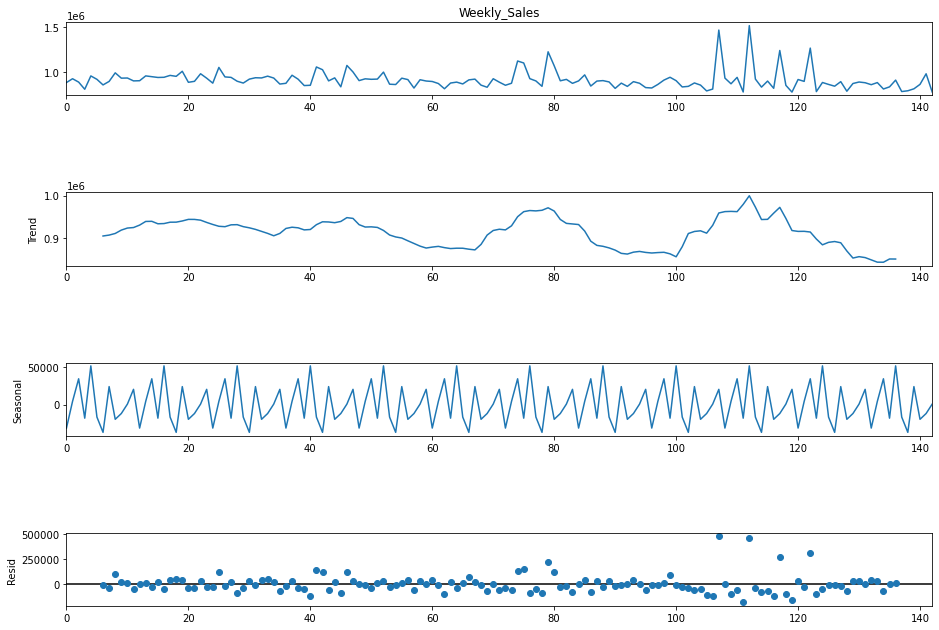

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales.Weekly_Sales, period=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()

In [ ]:
# resetting date back to the index
sales.set_index('Date',inplace = True)

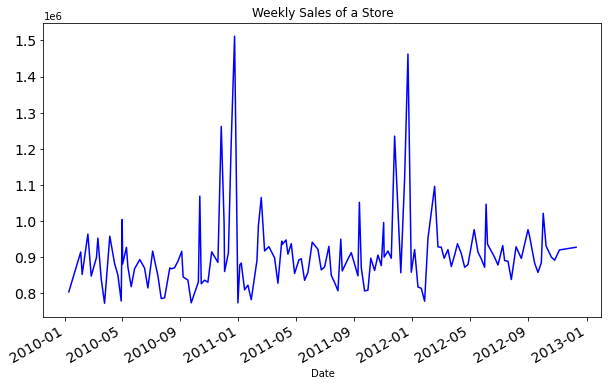

In [ ]:
sales.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of a Store', fontsize=14, color = 'blue')
plt.show()

In [ ]:
#lets compare the 2012 data of two stores
# Lets take store 5 data for analysis
store5 = data1[data1.Store == 5]
# there are about 45 different stores in this dataset.

sales5 = pd.DataFrame(store5.Weekly_Sales.groupby(store5.index).sum())
sales5.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales5.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales5['Date'] = pd.to_datetime(sales5['Date'])
# resetting date back to the index
sales5.set_index('Date',inplace = True)

In [ ]:
y1=sales.Weekly_Sales
y2=sales5.Weekly_Sales

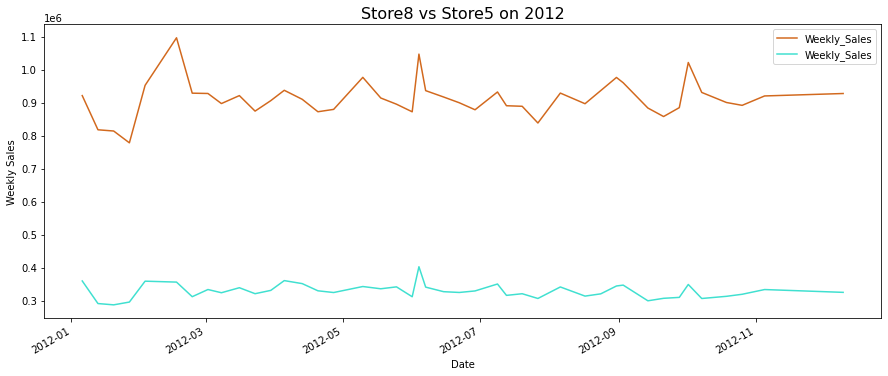

In [ ]:
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store8 vs Store5 on 2012', fontsize = '16')
plt.show()

In [ ]:
# Clearly we can see the irregularities

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)
import itertools
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [ ]:
seasonal_pdq

[(0, 0, 0, 52),
 (0, 0, 1, 52),
 (0, 0, 2, 52),
 (0, 0, 3, 52),
 (0, 0, 4, 52),
 (0, 1, 0, 52),
 (0, 1, 1, 52),
 (0, 1, 2, 52),
 (0, 1, 3, 52),
 (0, 1, 4, 52),
 (0, 2, 0, 52),
 (0, 2, 1, 52),
 (0, 2, 2, 52),
 (0, 2, 3, 52),
 (0, 2, 4, 52),
 (0, 3, 0, 52),
 (0, 3, 1, 52),
 (0, 3, 2, 52),
 (0, 3, 3, 52),
 (0, 3, 4, 52),
 (0, 4, 0, 52),
 (0, 4, 1, 52),
 (0, 4, 2, 52),
 (0, 4, 3, 52),
 (0, 4, 4, 52),
 (1, 0, 0, 52),
 (1, 0, 1, 52),
 (1, 0, 2, 52),
 (1, 0, 3, 52),
 (1, 0, 4, 52),
 (1, 1, 0, 52),
 (1, 1, 1, 52),
 (1, 1, 2, 52),
 (1, 1, 3, 52),
 (1, 1, 4, 52),
 (1, 2, 0, 52),
 (1, 2, 1, 52),
 (1, 2, 2, 52),
 (1, 2, 3, 52),
 (1, 2, 4, 52),
 (1, 3, 0, 52),
 (1, 3, 1, 52),
 (1, 3, 2, 52),
 (1, 3, 3, 52),
 (1, 3, 4, 52),
 (1, 4, 0, 52),
 (1, 4, 1, 52),
 (1, 4, 2, 52),
 (1, 4, 3, 52),
 (1, 4, 4, 52),
 (2, 0, 0, 52),
 (2, 0, 1, 52),
 (2, 0, 2, 52),
 (2, 0, 3, 52),
 (2, 0, 4, 52),
 (2, 1, 0, 52),
 (2, 1, 1, 52),
 (2, 1, 2, 52),
 (2, 1, 3, 52),
 (2, 1, 4, 52),
 (2, 2, 0, 52),
 (2, 2, 1, 52),
 (2, 2, 

### e. **Choosing Algorithm for Project**


In [ ]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 3, 1),
                                seasonal_order=(1, 4, 4, 52),   #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\harsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\harsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\harsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\harsh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be i

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0         -0        nan        nan           0          -0
ar.L2              -0         -0        nan        nan           0          -0
ar.L3               0         -0        nan        nan           0           0
ar.L4               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L52            0         -0        nan        nan           0           0
ma.S.L52            0         -0        nan        nan           0           0
ma.S.L104           0         -0        nan        nan           0           0
ma.S.L156           0         -0        nan        nan           0           0
ma.S.L208           0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.0

C:\Users\harsh\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3051: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  warnings.warn('Later subset of data for variable %d'
C:\Users\harsh\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\Users\harsh\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\harsh\anaconda3\lib\site-packages\statsmodels\tools\eval_measures.py:370: RuntimeWarning: invalid value encountered in log
  return -2. * llf + np.log(nobs) * df_modelwc
C:\Users\harsh\anaconda3\lib\site-packages\statsmodels\tools\eval_measures.py:394: RuntimeWarning: invalid value encountered in log
  return -2. * llf + 2 * np.log(np.log(nobs)) * df_modelwc
C:\Users\harsh\a

### f. **Motivation and Reasons for choosing the Algorithm**

Finally, I conclude that we will use **SARIMAX** Algorithm on this particular Time Series Data.

**Reason 1**:

After Ploting, It is visible, data had irregularities i.e. both seasonality and Trend. So, we had to go with SARIMAX

**Reason 2**:

After Differencing, In Adfuller Test, P-Value was well above critical limit. Hence, we concluded our data had irregularities and was non stationary.

**Reason 3**

The Main reason for choosing SARIMAX was actually suggested by autoarima, which is always more reliable

### g. **Assumptions**

In [ ]:
data1

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-05-02,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-12-02,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-05-03,1,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...
2012-09-28,45,713173.95,0,64.88,3.997,192.013558,8.684
2012-05-10,45,733455.07,0,64.89,3.985,192.170412,8.667
2012-12-10,45,734464.36,0,54.47,4.000,192.327265,8.667


### h. **Model Evaluation and Techniques**

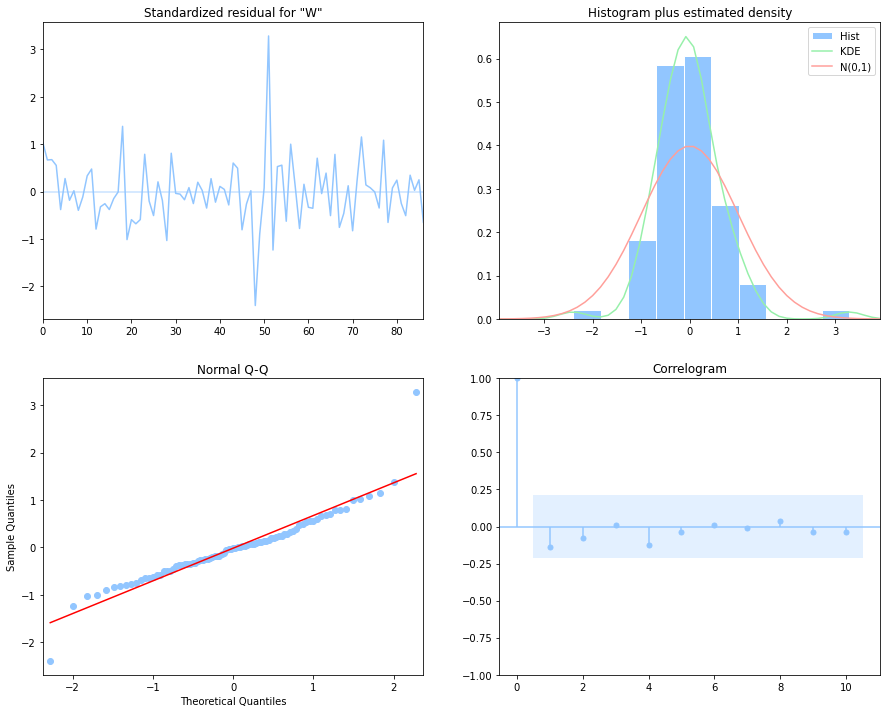

In [ ]:
plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

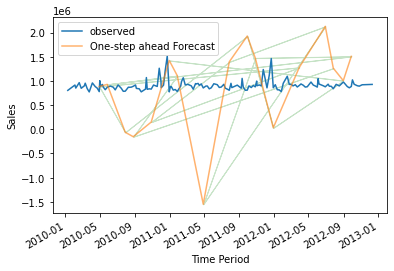

In [ ]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.6)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 28636274043.18


In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

C:\Users\HP\AppData\Local\Temp\ipykernel_8504\4127785946.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  ax = y1['2010':].plot(label='observed', figsize=(12, 8))


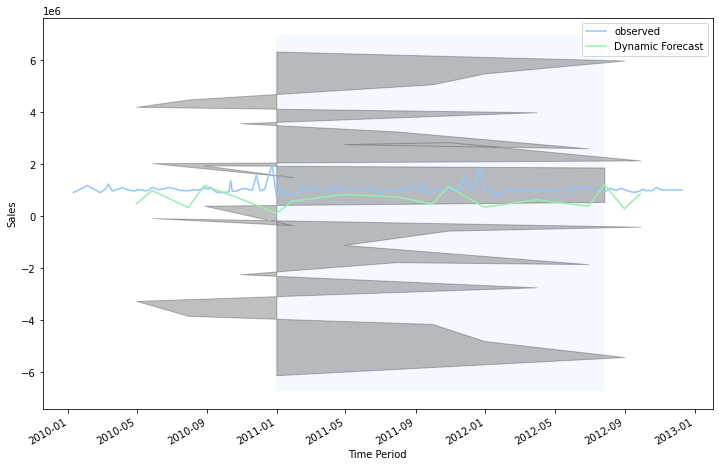

In [ ]:


ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()



In [ ]:
import numpy as np
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
print(y_forecasted)

Date
2012-07-27    1.205017e+06
2010-08-27    1.174084e+06
2011-01-28    5.742142e+05
2010-05-28    9.777730e+05
2012-09-28    8.650936e+05
2011-10-28    1.139981e+06
2011-04-29    8.276909e+05
2012-06-29    3.782356e+05
2011-07-29    7.410754e+05
2010-10-29    6.647317e+05
2012-03-30    6.252202e+05
2010-04-30    4.688193e+05
2010-07-30    3.216021e+05
2011-09-30    4.587662e+05
2011-12-30    3.399325e+05
2012-08-31    2.798574e+05
2010-12-31    1.031730e+05
Name: predicted_mean, dtype: float64


In [ ]:
y_truth = y1['2012-7-27':]

print(y_truth)

Date
2012-08-06    1061134.37
2012-09-03     991127.01
2012-10-02    1034448.07
2012-10-08     973812.79
2012-11-05     997868.63
2012-12-10    1004039.84
2012-09-14     918049.28
2012-08-17     981273.26
2012-10-19     978027.95
2012-09-21     921612.53
2012-08-24    1060906.75
2012-10-26    1094422.69
2012-07-27     925731.21
2012-09-28     976479.51
2012-08-31    1022270.86
Name: Weekly_Sales, dtype: float64


In [ ]:
# Compute the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 462451.92


In [ ]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())

Residual for Store1 1133085.4740104112


In [ ]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

print(pred_uc)

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

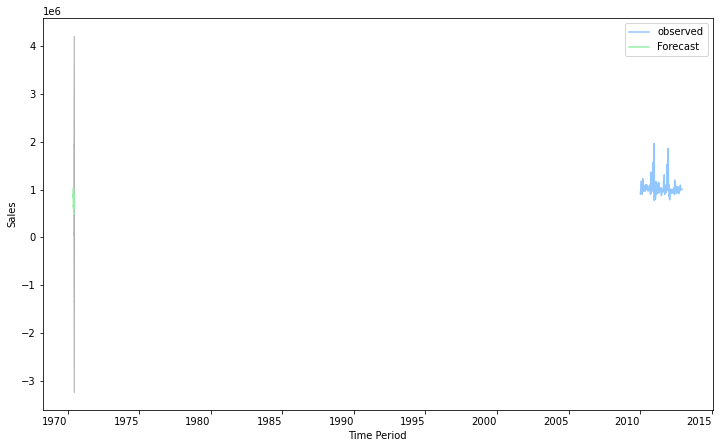

In [ ]:


ax = y1.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()



### i. **Inferences**

Size of the store is the highest contributing predictor in
the model out of all.

Each store has a unique prediction power. They can be separately analyzed to get prediction for each individual store

The Sales are very high during November and December and go down in January. So its better to employee more staff as casual employee in November and December and encourage permanent staff to take leaves during January.

The predicted sales data can be used to analyse the sales pattern and accordingly

### j. **Future Possibilities of Project**

For future prediction the model is not that great because the error interval is way big. But if we just check the blue line prediction this is almost like earlier years. If we look for may be first 2 weeks the prediction is way better and error is also low.